In [2]:
pip install resampy

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install python_speech_features

In [2]:
!pip install sounddevice

In [3]:
!pip install pyaudio

In [4]:
pip install librosa scikit-learn python_speech_features sounddevice tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install sounddevice

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from python_speech_features import mfcc
from tqdm import tqdm
import sounddevice as sd

In [11]:
def extract_mfcc_features(audio, sr=16000, num_cepstral=13, frame_length=0.02, frame_stride=0.02,
                           num_filters=32, fft_length=320, normalization_window=101, preemphasis_coeff=0.98):
    # Apply pre-emphasis
    audio = np.append(audio[0], audio[1:] - preemphasis_coeff * audio[:-1])

    # Compute the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=num_filters,
                                                 hop_length=int(frame_stride * sr),
                                                 win_length=int(frame_length * sr),
                                                 n_fft=fft_length, power=2.0)

    # Apply logarithm to the spectrogram to get log-mel energies
    log_mel_energy = np.log(spectrogram + 1e-9)

    # Extract MFCC features
    mfcc_features = librosa.feature.mfcc(S=log_mel_energy, n_mfcc=num_cepstral)

    # Apply mean and variance normalization across time
    mfcc_features = librosa.util.normalize(mfcc_features, norm=2, axis=0, fill=True)

    return mfcc_features

In [12]:
# Function to load data and preprocess
def preprocess_data(data_dir, test_size=0.2):
    labels = []
    features = []

    for class_label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_label)
        for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_label}"):
            file_path = os.path.join(class_path, file_name)
            audio, _ = librosa.load(file_path, res_type='kaiser_fast', duration=2.0, offset=0.0)
            mfcc_features = extract_mfcc_features(audio)
            features.append(mfcc_features)
            labels.append(class_label)

    features = np.array(features)
    labels = np.array(labels)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test,labels

In [13]:

# Determine the number of classes
import os

def train_model(features, labels, num_classes):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Reshape((13, -1)),
        layers.Conv1D(8, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        layers.Conv1D(16, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

    return model, encoder

# Define your data directory
data_dir = "/Users/doctorranjan/Desktop/yp/hackathon/Dataset"
print(os.path.exists(data_dir))
# Preprocess data
features, labels = preprocess_data(data_dir)
num_classes = len(set(labels))

# Train the model
trained_model, label_encoder = train_model(features, labels)

True


Processing door_close: 100%|████████████████| 3503/3503 [01:01<00:00, 57.17it/s]


ValueError: too many values to unpack (expected 2)

In [15]:
import os
from tqdm import tqdm
import librosa
import numpy as np

def combine_data(data_dir):
    data = []

    for class_label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_label)
        for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_label}"):
            file_path = os.path.join(class_path, file_name)
            audio, _ = librosa.load(file_path, sr = 16000)
            
            # Simply append the raw audio data to the dataset
            data.append({
                'audio': audio,
                'label': class_label
            })

    return data

# Example usage
data_dir = "/Users/doctorranjan/Desktop/yp/hackathon/Dataset"
dataset = combine_data(data_dir)

Processing door_close: 100%|███████████████| 3503/3503 [00:13<00:00, 260.75it/s]


In [21]:
import pandas as pd
data = pd.DataFrame(dataset)

In [22]:
data.head()

audio      label
0  [-0.019348145, -0.019592285, -0.019348145, -0....  door_stop
1  [0.019592285, 0.016906738, 0.019805908, 0.0188...  door_stop
2  [-0.026855469, -0.026855469, -0.03048706, -0.0...  door_stop
3  [0.0009460449, -0.0009765625, -0.0017089844, -...  door_stop
4  [0.0008544922, 0.0005493164, 9.1552734e-05, 0....  door_stop

In [24]:
#real time inference

# Real-time inference
def real_time_inference(model, encoder):
    duration = 1  # seconds
    sample_rate = 16000

    print("Listening for real-time inference...")

    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16,
                    channels=1,
                    rate=sample_rate,
                    input=True,
                    frames_per_buffer=int(sample_rate * duration))

    while True:
        # Record audio from the microphone
        audio_input = np.frombuffer(stream.read(int(sample_rate * duration), exception_on_overflow=False), dtype=np.int16)
        
        # Extract MFCC features from the audio input
        mfcc_features = extract_features(audio_input)

        # Perform real-time prediction
        prediction = model.predict([mfcc_features])

        # Inverse transform to get the predicted class label
        class_label = encoder.inverse_transform(prediction)[0]

        # Print the predicted class label
        print(f"Predicted class: {class_label}")

        # Check if the predicted class is "door open", "door close", "door stop" and exit the loop else continue in the grp
        if class_label == "door open":
            print(f"Predicted class: {class_label}")
            break
        elif class_label == "door close":
            print(f"Predicted class: {class_label}")
            break
        elif class_label == "door stop":
            print(f"Predicted class: {class_label}")
            break
        else:
            continue

    stream.stop_stream()
    stream.close()
    p.terminate()
# Define your data directory
data_directory = "/Users/doctorranjan/Desktop/yp/hackathon/Dataset"

# Preprocess data
features, labels = preprocess_data(data_directory)

# Train the model
trained_model, label_encoder = train_model(features, labels)

# Real-time inference
real_time_inference(trained_model, label_encoder)

Processing door_close: 100%|████████████████| 3503/3503 [00:46<00:00, 75.63it/s]


ValueError: too many values to unpack (expected 2)

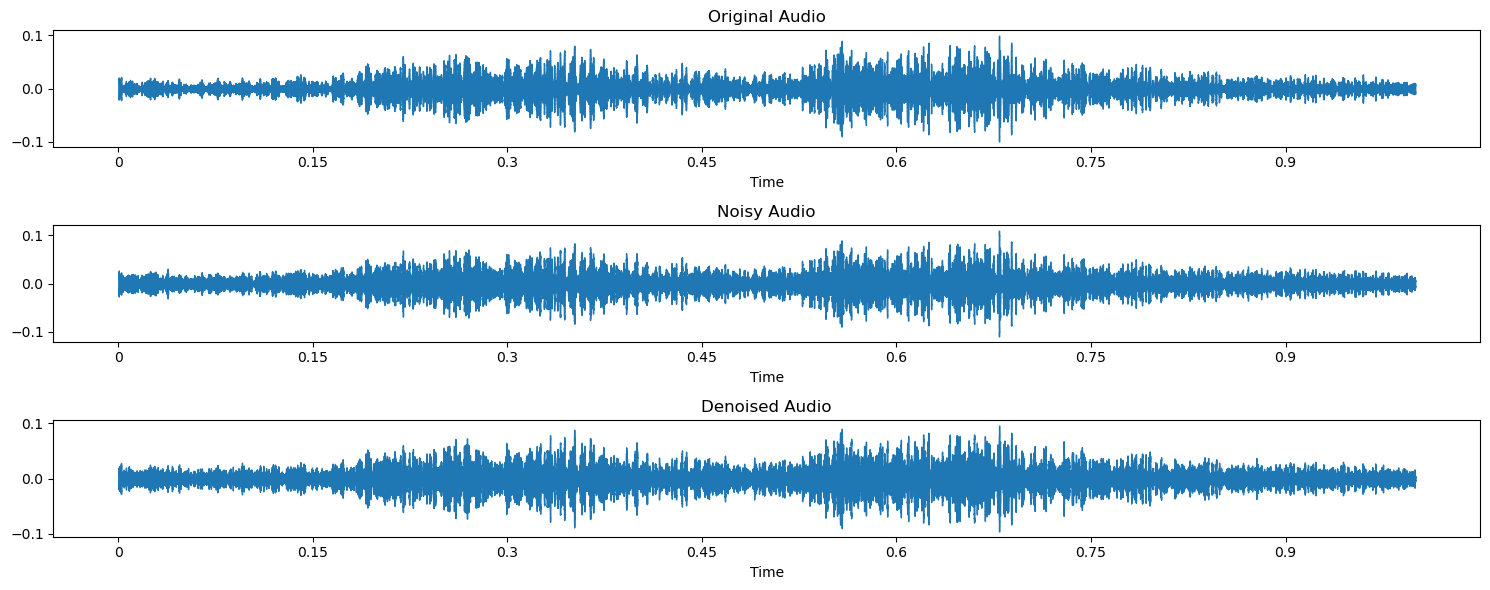

In [25]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Function to add Gaussian noise to audio
def add_gaussian_noise(audio, noise_level=0.005):
    noise = np.random.normal(0, noise_level, len(audio))
    noisy_audio = audio + noise
    return noisy_audio

# Function to denoise audio using spectral subtraction
def denoise_spectral_subtraction(audio, noise_level=0.005):
    # Add noise to the audio
    noisy_audio = add_gaussian_noise(audio, noise_level)

    # Apply spectral subtraction for denoising
    estimated_noise = librosa.effects.preemphasis(noisy_audio)
    denoised_audio = noisy_audio - estimated_noise

    return noisy_audio, denoised_audio

# Load the original audio
audio_path = "test1.wav"
original_audio, sr = librosa.load(audio_path, sr=None)

# Add Gaussian noise to the audio
noisy_audio, _ = denoise_spectral_subtraction(original_audio, noise_level=0.005)

# Visualize the original, noisy, and denoised audio
plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1)
librosa.display.waveshow(original_audio, sr=sr)
plt.title("Original Audio")

plt.subplot(3, 1, 2)
librosa.display.waveshow(noisy_audio, sr=sr)
plt.title("Noisy Audio")

# Denoise the audio using spectral subtraction
_, denoised_audio = denoise_spectral_subtraction(original_audio, noise_level=0.005)

plt.subplot(3, 1, 3)
librosa.display.waveshow(denoised_audio, sr=sr)
plt.title("Denoised Audio")

plt.tight_layout()
plt.show()


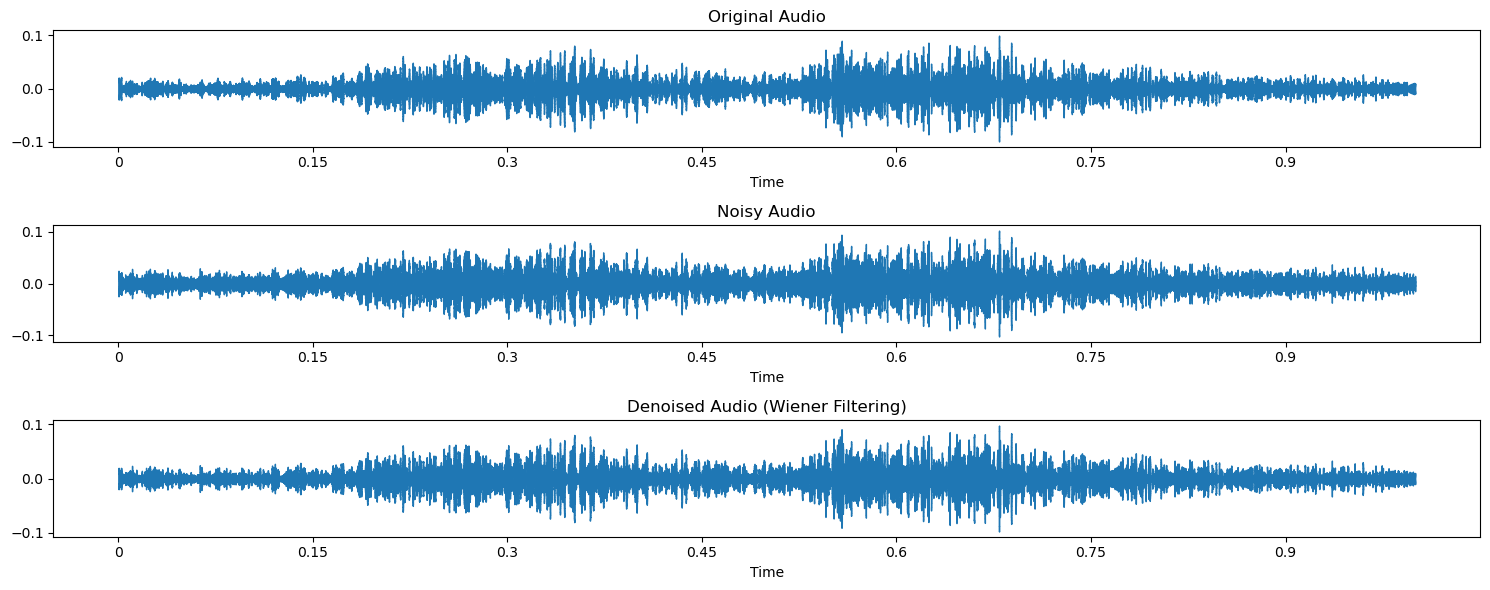

In [26]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener

# Function to add noise to audio
def add_noise(audio, noise_level=0.005):
    noise = np.random.normal(0, noise_level, len(audio))
    noisy_audio = audio + noise
    return noisy_audio

# Function to apply Wiener filtering for denoising
def wiener_denoise(audio):
    denoised_audio = wiener(audio)
    return denoised_audio

# Load the original audio
audio_path = "test1.wav"
original_audio, sr = librosa.load(audio_path, sr=None)

# Add Gaussian noise to the audio
noisy_audio = add_noise(original_audio, noise_level=0.005)

# Apply Wiener filtering for denoising
denoised_audio = wiener_denoise(noisy_audio)

# Plot the original, noisy, and denoised audio signals
plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1)
librosa.display.waveshow(original_audio, sr=sr)
plt.title("Original Audio")

plt.subplot(3, 1, 2)
librosa.display.waveshow(noisy_audio, sr=sr)
plt.title("Noisy Audio")

plt.subplot(3, 1, 3)
librosa.display.waveshow(denoised_audio, sr=sr)
plt.title("Denoised Audio (Wiener Filtering)")

plt.tight_layout()
plt.show()


In [27]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener

# Function to add noise to audio
def add_noise(audio, noise_level=0.005):
    noise = np.random.normal(0, noise_level, len(audio))
    noisy_audio = audio + noise
    return noisy_audio

# Function to apply Wiener filtering for denoising
def wiener_denoise(audio):
    denoised_audio = wiener(audio)
    return denoised_audio

# Load the original audio
audio_path = "test1.wav"
original_audio, sr = librosa.load(audio_path, sr=None)

# Add Gaussian noise to the audio
noisy_audio = add_noise(original_audio, noise_level=0.005)

# Apply Wiener filtering for denoising
denoised_audio = wiener_denoise(noisy_audio)

# Save the denoised audio to a new file
output_path = "output.wav"
librosa.output.write_wav(output_path, denoised_audio, sr)

# Plot the original, noisy, and denoised audio signals
plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1)
librosa.display.waveshow(original_audio, sr=sr)
plt.title("Original Audio")

plt.subplot(3, 1, 2)
librosa.display.waveshow(noisy_audio, sr=sr)
plt.title("Noisy Audio")

plt.subplot(3, 1, 3)
librosa.display.waveshow(denoised_audio, sr=sr)
plt.title("Denoised Audio (Wiener Filtering)")

plt.tight_layout()
plt.show()


AttributeError: No librosa attribute output

In [28]:
graph TD
    id1[Input Layer]
    id2[Conv2D: 8 filters, 3x3 kernel, ReLU]
    id3[MaxPooling2D: 2x2 pool]
    id4[Dropout: 0.25 rate]
    id5[Conv2D: 16 filters, 3x3 kernel, ReLU]
    id6[MaxPooling2D: 2x2 pool]
    id7[Dropout: 0.25 rate]
    id8[Flatten Layer]
    id9[Dense Layer: Softmax activation]

    id1 --> id2
    id2 --> id3
    id3 --> id4
    id4 --> id5
    id5 --> id6
    id6 --> id7
    id7 --> id8
    id8 --> id9

SyntaxError: invalid decimal literal (738118539.py, line 3)